# pipegraph User Guide

## Rationale

[scikit-learn](http://scikit-learn.org/stable/) provides a useful set of data preprocessors and machine learning models. The `Pipeline` object can effectively encapsulate a chain of transformers followed by final model. Other functions, like `GridSearchCV` can effectively use `Pipeline` objects to find the set of parameters that provide the best estimator.

### Pipeline + GridSearchCV: an awesome combination
Let's consider a simple example to illustrate the advantages of using `Pipeline` and `GridSearchCV`.

First let's import the libraries we will use and then let's build some artificial data set following a simple polynomial rule

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

X = 2*np.random.rand(100,1)-1
y = 40 * X**5 + 3*X*2 +  3*X + 3*np.random.randn(100,1)

Once we have some data ready, we instantiate the transformers and a regressor we want to fit:

In [2]:
scaler = MinMaxScaler()
polynomial_features = PolynomialFeatures()
linear_model = LinearRegression()

We define the steps that form the Pipeline object and then we instantiate such a Pipeline

In [3]:
steps = [('scaler', scaler),
         ('polynomial_features', polynomial_features),
         ('linear_model', linear_model)]

pipe = Pipeline(steps=steps)

Now we can pass this pipeline to `GridSearchCV`. When the `GridSearchCV` object is fitted, the search for the best combination for hyperparameters is performed according to the values provided in the `param_grid` parameter:

In [4]:
param_grid = {'polynomial_features__degree': range(1, 11),
              'linear_model__fit_intercept': [True, False]}

grid_search_regressor = GridSearchCV(estimator=pipe, param_grid=param_grid, refit=True)
grid_search_regressor.fit(X, y);

And now we can check the results of fitting the Pipeline and the values of the hyperparameters:

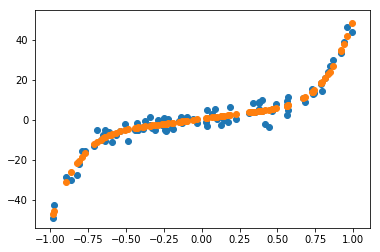

In [5]:
y_pred = grid_search_regressor.predict(X)
plt.scatter(X, y)
plt.scatter(X, y_pred)
plt.show()

In [6]:
coef = grid_search_regressor.best_estimator_.get_params()['linear_model'].coef_
degree = grid_search_regressor.best_estimator_.get_params()['polynomial_features'].degree

print('Information about the parameters of the best estimator: \n degree: {} \n coefficients: {} '.format(degree, coef))

Information about the parameters of the best estimator: 
 degree: 5 
 coefficients: [[    0.           443.10816501 -1849.10331869  3922.58622592 -4040.9186163
   1619.79333825]] 


### Pipeline weaknesses:
From this example we can learn that `Pipeline` and `GridSearchCV` are very useful tools to consider when attempting to fit models. As far as the needs of the user can be satisfied by a set of transformers followed by a final model, this approach seems to be highly convenient. Additional advantages of such approach are the **parallel computation** and **memoization** capabilities of GridSearchCV.

Unfortunately though, current implementation of scikit-learn's `Pipeline`:
- Does not allow postprocessors after the final model
- Does not allow extracting information about intermediate results
- The X is transformed on every transformer but the following step can not have access to X variable values beyond the previous step
- Only allows single path workflows

### pipegraph goals:
[pipegraph](https://github.com/mcasl/PipeGraph) was programmed in order to allow researchers and practitioners to:
- Use multiple path workflows
- Have access to every variable value produced by any step of the workflow
- Use an arbitraty number of models and transformers in the way the user prefers
- Express the model as a graph consisting of transformers, regressors, classifiers or custom blocks
- Build new custom block in an easy way
- Provide the community some adapters to scikit-learn's objects that may help further developments

## pipegraph main interface: The PipeGraphRegressor and PipeGraphClassifier classes
`pipegraph` provides the user two main classes: `PipeGraphRegressor` and `PipeGraphClassifier`. They both provide a familiar interface to the raw `PipeGraph` class that most users will not need to use. The `PipeGraph` class provides greater versatility allowing an arbitrary number of inputs and outputs and may be the base class for those users facing applications with such special needs. Most users, though, will be happy using just the former two classes provided as main interface to operate the library.

As the names intend to imply, `PipeGraphRegressor` is the class to use for regression models and `PipeGraphClassifier` is intended for classification problems. Indeed, the only difference between these two classes is the default scoring function that has been chosen accordingly to scikit-learn defaults for each case. Apart from that, both classes share the same code. It must be noticed though, that any of these classes can comprise a plethora of different regressors or clasiffiers. It is the final step the one that will define whether we are defining a classification or regression problem.

## From a single path workflow to a graph with multiple paths: Understanding connections
Theses two classes provide an interface as similar to scikit-learn's `Pipeline` as possible in order to ease their use to those already familiar with scikit-learn. There is a slight but important difference that empowers these two classes: the `PipeGraph` related classes accept extra information about which input variables are needed by each step, thus allowing multiple path workflows. 

To clarify the usage of these connections, let's start using `pipegraph` with a simple example that could be otherwise perfectly expressed using a scikit-learn's `Pipeline` as well. In this simple case, the data is transformed using a `MinMaxScaler` transformer and the preprocessed data is fed to a `LinearRegression` model. Figure 1 shows the steps of this PipeGraphRegressor and the connections between them: which input variables each one accepts and their origin, that is, if they are provided by a previous step, like the output of `scaler`, named `predict`, that is used by `linear_model`'s `X` variable; or `y` which is not calculated by any previous block but is passed by the user in the `fit` or `predict` method calls.

<img src="./images/figure_1-a.png" width="400" />
Figure 1. PipeGraph diagram showing the steps and their connections

In this first simple example of `pipegraph` the last step is a regressor, and thus the `PipeGraphRegressor` class is the most adequate class to choose. But other than that, we define the steps as usual for a standard `Pipeline`: as a list of tuples (label, sklearn object). We are not introducing yet any information at all about the connections, in which case the `PipeGraphRegressor` object is built considering that the steps follow a linear workflow in the same way as a standard `Pipeline`.

In [7]:
from pipegraph import PipeGraphRegressor

X = 2*np.random.rand(100,1)-1
y = 40 * X**5 + 3*X*2 +  3*X + 3*np.random.randn(100,1)

scaler = MinMaxScaler()
linear_model = LinearRegression()
steps = [('scaler', scaler),
         ('linear_model', linear_model)]

pgraph = PipeGraphRegressor(steps=steps)
pgraph.fit(X, y)

ModuleNotFoundError: No module named 'pipegraph'

As the printed output shows, the internal links displayed by the `fit_connections` and `predict_connections` parameters are in line with those we saw in Figure 1 and those expected by a single path pipeline. As we did not specify these values, they were created by `PipeGRaphRegressor.__init__()` method as a comodity. We can have a look at these values by directly inspecting the attributes values. As `PipeGraphRegressor` and `PipeGraphClassifier` are wrappers of a `PipeGraph` object stored in the `_pipegraph` attribute, we have to dig a bit deeper to find the `fit_connections`

In [ ]:
pgraph._pipegraph.fit_connections

Figure 2 surely will help understading the syntax used by the connections dictionary. It goes like this:
- The keys of the top level entries of the dictionary must be the same as those of the previously defined steps.
- The values assocciated to these keys define the variables from other steps that are going to be considered as inputs for the current step. They are dictionaries themselves, where:

   - The keys of the nested dictionary represent the input variables as named at the current step.
   - The values assocciated to these keys define the steps that hold the desired information and the variables as named at that step. This information can be written as:

     - A tuple with the label of the step in position 0 followed by the name of the output variable in position 1.
     - A string:
         - If the string value is one of the labels from the steps, then it is interpreted as tuple, as previously, with the label of the step in position 0 and 'predict' as name of the output variable in position 1.
         - Otherwise, it is considered to be a variable from an external source, such as those provided by the user while invoking the ``fit``, ``predict`` or ``fit_predict`` methods.


<img src="./images/figure_1-b.png" width="700" />

Figure 2. Illustration of the connections of the PipeGraph

The choice of name 'predict' for default output variables was made for convenience reasons as it will be illustrated later on. The developers preferred using always the same word for every block even though it might not be a regressor nor a classifier.

Finally, let's get the predicted values from this `PipeGraphRegressor` for illustrative purposes:

In [ ]:
y_pred = pgraph.predict(X)
plt.scatter(X, y, label='Original Data')

plt.scatter(X, y_pred, label='Predicted Data')
plt.title('Plots of original and predicted data')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Index')
plt.ylabel('Value of Data')
plt.show()

## `GridSearchCV` compatibility requirements

Both `PipeGraphRegressor`and `PipeGraphClassifier` are compatible with `GridSearchCV` provided the last step can be scored, either:
- by using `PipeGraphRegressor` or `PipeGraphClassifier` default scoring functions,
- by implementing a custom scoring function capable of handling that last step inputs and outputs,
- by using a `NeutralRegressor` or `NeutralClassifier` block as final step.

Those pipegraphs with a last step from scikit-learn's estimators set will work perfectly well using `PipeGraphRegressor` or `PipeGraphClassifier` default scoring functions. The other two alternative cover those cases in which a custom block with non standard inputs is provided. In that case, choosing a neutral regressor or classifier is usually a much simpler approach than writing customs scoring function. `NeutralRegressor` or `NeutralClassifier` are two classes provided for users convenience so that no special scoring function is needed. They just allow the user to pick some variables from other previous steps as `X` and `y` and provide compatibility to use a default scoring function.  

### Example using default scoring functions
We will show more complex examples in what follows, but let's first illustrate with a simple example how to use `GrisSearchCV` with the default scoring functions. Figure 3 shows the steps of the model:
- **scaler**: a preprocessing step using a `MinMaxScaler` object,
- **polynomial_features**: a transformer step that  generates a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified one,
- **linear_model**: the `LinearRegression` object we want to fit.

<img src="./images/figure_2.png" width="700" />

Figure 3. Using a PipeGraphRegressor object as estimator by GridSearchCV

Firstly, we import the necessary libraries and create some artificial data.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

X = 2*np.random.rand(100,1)-1
y = 40 * X**5 + 3*X*2 +  3*X + 3*np.random.randn(100,1)

scaler = MinMaxScaler()
polynomial_features = PolynomialFeatures()
linear_model = LinearRegression()

Secondly, we define the steps and a ``param_grid`` dictionary as specified by `GridSearchCV`.
In this case we just want to explore a few possibilities varying the degree of the polynomials and whether to use or not an intercept at the linear model.

In [ ]:
steps = [('scaler', scaler),
         ('polynomial_features', polynomial_features),
         ('linear_model', linear_model)]

param_grid = {'polynomial_features__degree': range(1, 11),
              'linear_model__fit_intercept': [True, False]}

Now, we use ``PipeGraphRegressor`` as estimator for `GridSearchCV` and perform the ``fit`` and ``predict`` operations. As  the last steps, a linear regressor from scikit-learn,  already works with the default scoring functions, no extra efforts are needed to make it compatible with `GridSearchCV`.

In [ ]:
pgraph = PipeGraphRegressor(steps=steps)
grid_search_regressor = GridSearchCV(estimator=pgraph, param_grid=param_grid, refit=True)
grid_search_regressor.fit(X, y)
y_pred = grid_search_regressor.predict(X)

plt.scatter(X, y)
plt.scatter(X, y_pred)
plt.show()


coef = grid_search_regressor.best_estimator_.get_params()['linear_model'].coef_
degree = grid_search_regressor.best_estimator_.get_params()['polynomial_features'].degree

print('Information about the parameters of the best estimator: \n degree: {} \n coefficients: {} '.format(degree, coef))

This example showed how to use `GridSearchCV` with `PipeGraphRegressor` in a simple single path workflow with default scoring functions. Let's explore in next section a more complex example.


## Multiple path workflow examples

Untill now, all the examples we showed displayed a single path sequence of steps and thus they could have been equally easily done using sickit-learn standard `Pipeline`. We are going to show now in the following examples multiple path cases in which we illustrate some compatibility constrains that occur and how to deal with them successfully.

### Example: Injecting a varying vector in the sample_weight parameter of LinearRegression
This example illustrates the case in which a varying vector is injected to a linear regression model as ``sample_weight`` in order to evaluate them and obtain the sample_weight that generates the best results. 

The steps of this model  are shown in Figure 4. To perform such experiment, the following issues appear:

- The shape of the graph is not a single path workflow as those that can be implemented using Pipeline. Thus, we need to use `pipegraph`.

- The model has 3 input variables, `X`, `y`, and `sample_weight`. The `Pipegraph` class can accept an arbitrary number of input variables, but, in order to use scikit-learn's current implementation of GridSearchCV, only `X` and `y` are accepted. We can do the trick but previously concatenating `X` and `sample_weight` into a single pandas DataFrame, for example, in order to comply with GridSearchCV requisites. That implies that the graph must be capable of separating afterwards the augmented `X` into the two components again. The **selector** step is in charge of this splitting. This step features a `ColumnSelector` custom step. This is not a scikit-learn original object but a custom class that allows to split an array into columns. In this case, ``X`` augmented data is column-wise divided as specified in a mapping dictionary. We will talk later on about custom blocks.

- The information provided to the  ``sample_weight`` parameter of the LinearRegression step varies on the different scenarios explored by GridSearchCV. In a GridSearchCV with Pipeline, ``sample_weight`` can't vary because it is treated as a ``fit_param`` instead of a variable. Using pipegraph's connections this is no longer a problem.

- As we need a custom transformer to apply the power function to the sample_weight vector, we implement the **custom_power** step featuring a `CustomPower` custom class. Again, we will talk later on about custom blocks.

The three other steps from the model are already known:
- **scaler**: implements `MinMaxScaler` class
- **polynomial_features**: Contains a `PolynomialFeatures` object
- **linear_model**: Contains a `LinearRegression` model

<img src="./images/figure_3.png" width="600" />

    Figure 4. A multipath model

Let's import the new components:

In [ ]:
import pandas as pd
from pipegraph.base import ColumnSelector
from pipegraph.demo_blocks import CustomPower

We create an augmented ``X`` in which all data but ``y`` is concatenated. In this case, we concatenate ``X`` and ``sample_weight`` vector.

In [ ]:
X = pd.DataFrame(dict(X=np.array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11]),
          sample_weight=np.array([0.01, 0.95, 0.10, 0.95, 0.95, 0.10, 0.10, 0.95, 0.95, 0.95, 0.01])))
y = np.array(                    [  10,    4,   20,   16,   25 , -60,   85,   64,   81,  100,  150])

Next we define the steps and we use `PipeGraphRegressor` as estimator for `GridSearchCV`.

In [ ]:
scaler = MinMaxScaler()
polynomial_features = PolynomialFeatures()
linear_model = LinearRegression()
custom_power = CustomPower()
selector = ColumnSelector(mapping={'X': slice(0, 1),
                                   'sample_weight': slice(1,2)})

steps = [('selector', selector),
         ('custom_power', custom_power),
         ('scaler', scaler),
         ('polynomial_features', polynomial_features),
         ('linear_model', linear_model)]

pgraph = PipeGraphRegressor(steps=steps)

Now, we have to define the connections of the model. We could have specified a dictionary containing the connections, but [as suggested by Joel Nothman](https://github.com/scikit-learn-contrib/scikit-learn-contrib/issues/28), scikit-learn users might find more convenient to use a method `inject` like in this example. Let's see `inject`s docstring:

In [ ]:
import inspect
print(inspect.getdoc(pgraph.inject))

`inject` allows to chain different calls to progressively describe all the connections needed in an easy to read manner:

In [ ]:
(pgraph.inject(sink='selector', sink_var='X', source='_External', source_var='X')
       .inject('custom_power', 'X', 'selector', 'sample_weight')
       .inject('scaler', 'X', 'selector', 'X')
       .inject('polynomial_features', 'X', 'scaler')
       .inject('linear_model', 'X',  'polynomial_features')
       .inject('linear_model', 'y', source_var='y')
       .inject('linear_model', 'sample_weight', 'custom_power'))

Then we define ``param_grid`` as expected by `GridSearchCV` to explore several possibilities of varying parameters.
        

In [ ]:
param_grid = {'polynomial_features__degree': range(1, 3),
              'linear_model__fit_intercept': [True, False],
              'custom_power__power': [1, 5, 10, 20, 30]}



grid_search_regressor = GridSearchCV(estimator=pgraph, param_grid=param_grid, refit=True)
grid_search_regressor.fit(X, y)
y_pred = grid_search_regressor.predict(X)

plt.scatter(X.loc[:,'X'], y)
plt.scatter(X.loc[:,'X'], y_pred)
plt.show()

power = grid_search_regressor.best_estimator_.get_params()['custom_power']
print('Power that obtains the best results in the linear model: \n {}'.format(power))

This example showed how to solve current limitations of scikit-learn `Pipeline`:
- Displayed a multipath workflow successfully implemented by **pipegraph**
- Showed how to circumvent current limitations of standard `GridSearchCV`, in particular, the restriction on the number of input parameters
- Showed the flexibility of **pipegraph** for specifying the connections in an easy to read manner using the `inject` method
- Demonstrated the capability of injecting previous steps' output into other models parameters, such as it is the case of the sample_weight parameter in the linear regressor.

### Example: Combination of classifiers

A set of classifiers is combined as input to a neural network. Additionally, the scaled inputs are injected as well to
the neural network. The data is firstly transformed by scaling its features.

Steps of the **PipeGraph**:

- **scaler**: A `MinMaxScaler` data preprocessor
- **gaussian_nb**: A `GaussianNB` classifier
- **svc**: A `SVC` classifier
- **concat**: A `Concatenator` custom class that appends the outputs of the `GaussianNB`, `SVC` classifiers, and the scaled inputs.
- **mlp**: A `MLPClassifier` object

<img src="./images/figure_4.png" width="700" />

Figure 5. PipeGraph diagram showing the steps and their connections

In [ ]:
from pipegraph.base import PipeGraphClassifier, Concatenator
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X = iris.data
y = iris.target

scaler = MinMaxScaler()
gaussian_nb = GaussianNB()
svc = SVC()
mlp = MLPClassifier()
concatenator = Concatenator()

steps = [('scaler', scaler),
         ('gaussian_nb', gaussian_nb),
         ('svc', svc),
         ('concat', concatenator),
         ('mlp', mlp)]

In this example we use a `PipeGraphClassifier` because the result is a classification and we want to take advantage of scikit-learn default scoring method for classifiers. Once more, we use the `inject` chain of calls to define the connections.

In [ ]:
pgraph = PipeGraphClassifier(steps=steps)
(pgraph.inject(sink='scaler', sink_var='X', source='_External', source_var='X')
       .inject('gaussian_nb', 'X', 'scaler')
       .inject('gaussian_nb', 'y', source_var='y')
       .inject('svc', 'X', 'scaler')
       .inject('svc', 'y', source_var='y')
       .inject('concat', 'X1', 'scaler')
       .inject('concat', 'X2', 'gaussian_nb')
       .inject('concat', 'X3', 'svc')
       .inject('mlp', 'X', 'concat')
       .inject('mlp', 'y', source_var='y')
)

param_grid = {'svc__C': [0.1, 0.5, 1.0],
              'mlp__hidden_layer_sizes': [(3,), (6,), (9,),],
              'mlp__max_iter': [5000, 10000]}

grid_search_classifier  = GridSearchCV(estimator=pgraph, param_grid=param_grid, refit=True)
grid_search_classifier.fit(X, y)
y_pred = grid_search_classifier.predict(X)

grid_search_classifier.best_estimator_.get_params()

In [ ]:
# Code for plotting the confusion matrix taken from 'Python Data Science Handbook' by Jake VanderPlas
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()  # for plot styling

mat = confusion_matrix(y_pred, y)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

This example displayed complex data injections that are successfully managed by **pipegraph**.

###  Example: Demultiplexor - multiplexor

An imaginative layout using a classifier to predict the cluster labels and fitting a separate model for each cluster. We will elaborate on this example in the examples that follow introducing variations. AS the Figure shows, the steps of the **PipeGraph** are:

- **scaler**: A :class:`MinMaxScaler` data preprocessor
- **classifier**: A :class:`GaussianMixture` classifier
- **demux**: A custom :class:`Demultiplexer` class in charge of splitting the input arrays accordingly to the selection input vector
- **lm_0**: A :class:`LinearRegression` model
- **lm_1**: A :class:`LinearRegression` model
- **lm_2**: A :class:`LinearRegression` model
- **mux**: A custom :class:`Multiplexer` class in charge of combining different input arrays into a single one accordingly to the selection input vector

<img src="./images/figure_5.png" width="700" />

Figure 6. PipeGraph diagram showing the steps and their connections

In [ ]:
from pipegraph.base import PipeGraphRegressor, Demultiplexer, Multiplexer
from sklearn.mixture import GaussianMixture

X_first = pd.Series(np.random.rand(100,))
y_first = pd.Series(4 * X_first + 0.5*np.random.randn(100,))
X_second = pd.Series(np.random.rand(100,) + 3)
y_second = pd.Series(-4 * X_second + 0.5*np.random.randn(100,))
X_third = pd.Series(np.random.rand(100,) + 6)
y_third = pd.Series(2 * X_third + 0.5*np.random.randn(100,))

X = pd.concat([X_first, X_second, X_third], axis=0).to_frame()
y = pd.concat([y_first, y_second, y_third], axis=0).to_frame()

scaler = MinMaxScaler()
gaussian_mixture = GaussianMixture(n_components=3)
demux = Demultiplexer()
lm_0 = LinearRegression()
lm_1 = LinearRegression()
lm_2 = LinearRegression()
mux = Multiplexer()


steps = [('scaler', scaler),
         ('classifier', gaussian_mixture),
         ('demux', demux),
         ('lm_0', lm_0),
         ('lm_1', lm_1),
         ('lm_2', lm_2),
         ('mux', mux), ]

Instead of using ``inject`` as in previous example, in this one we are going to pass a dictionary describing the connections to PipeGraph constructor

In [ ]:
connections = { 'scaler': {'X': 'X'},
                'classifier': {'X': 'scaler'},
                'demux': {'X': 'scaler',
                          'y': 'y',
                          'selection': 'classifier'},
                'lm_0': {'X': ('demux', 'X_0'),
                         'y': ('demux', 'y_0')},
                'lm_1': {'X': ('demux', 'X_1'),
                         'y': ('demux', 'y_1')},
                'lm_2': {'X': ('demux', 'X_2'),
                         'y': ('demux', 'y_2')},
                'mux': {'0': 'lm_0',
                        '1': 'lm_1',
                        '2': 'lm_2',
                        'selection': 'classifier'}}

pgraph = PipeGraphRegressor(steps=steps, fit_connections=connections)
pgraph.fit(X, y)

y_pred = pgraph.predict(X)
plt.scatter(X, y)
plt.scatter(X, y_pred)
plt.show()

### Example: Encapsulating several blocks into a PipeGraph and reusing it


We consider the previous example in which we had the following pipegraph model:



<img src="./images/figure_6.png" width="700" />

We can be interested in using a fragment of the pipegraph, for example, those blocks marked with the circle (the Demultiplexer, the linear model collection, and the Multiplexer), as a single block in another pipegraph:

<img src="./images/figure_7.png" width="500" />

We prepare the data and build a PipeGraph with these steps alone:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from pipegraph.base import PipeGraph, PipeGraphRegressor, Demultiplexer, Multiplexer

# Prepare some artificial data

X_first = pd.Series(np.random.rand(100,))
y_first = pd.Series(4 * X_first + 0.5*np.random.randn(100,))
X_second = pd.Series(np.random.rand(100,) + 3)
y_second = pd.Series(-4 * X_second + 0.5*np.random.randn(100,))
X_third = pd.Series(np.random.rand(100,) + 6)
y_third = pd.Series(2 * X_third + 0.5*np.random.randn(100,))

X = pd.concat([X_first, X_second, X_third], axis=0).to_frame()
y = pd.concat([y_first, y_second, y_third], axis=0).to_frame()

In [ ]:
# Create a single complex block

demux = Demultiplexer()
lm_0 = LinearRegression()
lm_1 = LinearRegression()
lm_2 = LinearRegression()
mux = Multiplexer()

three_multiplexed_models_steps = [
         ('demux', demux),
         ('lm_0', lm_0),
         ('lm_1', lm_1),
         ('lm_2', lm_2),
         ('mux', mux), ]

three_multiplexed_models_connections = {
                'demux': {'X': 'X',
                          'y': 'y',
                          'selection': 'selection'},
                'lm_0': {'X': ('demux', 'X_0'),
                         'y': ('demux', 'y_0')},
                'lm_1': {'X': ('demux', 'X_1'),
                         'y': ('demux', 'y_1')},
                'lm_2': {'X': ('demux', 'X_2'),
                         'y': ('demux', 'y_2')},
                'mux': {'0': 'lm_0',
                        '1': 'lm_1',
                        '2': 'lm_2',
                        'selection': 'selection'}}

three_multiplexed_models = PipeGraph(steps=three_multiplexed_models_steps,
                                     fit_connections=three_multiplexed_models_connections )

Now we can treat this PipeGraph as a reusable component and use it as a unitary step in another PipeGraph:

In [ ]:
scaler = MinMaxScaler()
gaussian_mixture = GaussianMixture(n_components=3)
models = three_multiplexed_models

steps = [('scaler', scaler),
         ('classifier', gaussian_mixture),
         ('models', three_multiplexed_models), ]

connections = {'scaler': {'X': 'X'},
               'classifier': {'X': 'scaler'},
               'models': {'X': 'scaler',
                          'y': 'y',
                          'selection': 'classifier'},
               }

pgraph = PipeGraphRegressor(steps=steps, fit_connections=connections)
pgraph.fit(X, y)
y_pred = pgraph.predict(X)
plt.scatter(X, y)
plt.scatter(X, y_pred)
plt.show()

### Example: Dynamically built component using initialization parameters

Last section showed how the user can choose to encapsulate several blocks into a PipeGraph and use it as a single unit in another PipeGraph. Now we will see how these components can be dynamically built on runtime depending on initialization parameters.

<img src="./images/figure_8.png" width="700" />

We can think of programatically changing the number of regression models inside this component we isolated in the previous example. First we do it by using initialization parameters in a ``PipeGraph`` subclass we called ``pipegraph.base.RegressorsWithParametrizedNumberOfReplicas``:

In [ ]:
import inspect
from pipegraph.base import RegressorsWithParametrizedNumberOfReplicas

print(inspect.getsource(RegressorsWithParametrizedNumberOfReplicas))

As it can be seen from the source code,  in this example we are basically interested in using a PipeGraph object whose `__init__` has different parameters than the usual ones. Thus, we subclass PipeGRaph and reimplement the `__init__` method. In doing so, we are capable of working out the structure of the steps and connections before calling the `super().__init__` method that provides the regular `PipeGraph` object.

Using this new component we can build a PipeGraph with as many multiplexed models as given by the `number_of_replicas` parameter:

In [ ]:
scaler = MinMaxScaler()
gaussian_mixture = GaussianMixture(n_components=3)
models = RegressorsWithParametrizedNumberOfReplicas(number_of_replicas=3,
                                                    model_prototype=LinearRegression(),
                                                    model_parameters={})

steps = [('scaler', scaler),
         ('classifier', gaussian_mixture),
         ('models', models), ]

connections = {'scaler': {'X': 'X'},
               'classifier': {'X': 'scaler'},
               'models': {'X': 'scaler',
                          'y': 'y',
                          'selection': 'classifier'},
               }

pgraph = PipeGraphRegressor(steps=steps, fit_connections=connections)
pgraph.fit(X, y)
y_pred = pgraph.predict(X)
plt.scatter(X, y)
plt.scatter(X, y_pred)
plt.show()

### Example: Dynamically built component using input signal values during the fit stage

Last example showed how to grow a PipeGraph object programatically during runtime using the `__init__` method. In this example, we are going to show how we can change the internal structure of a PipeGraph object, not during initialization but during fit. Specifically, we will show how the multiplexed model can be dynamically added on runtime depending on input signal values during `fit`.


Now we consider the possibility of using the classifier's output to automatically adjust the number of replicas.
This can be seen as PipeGraph changing its inner topology to adapt its connections and steps to other components
context. This morphing capability opens interesting possibilities to explore indeed.

In [ ]:
import inspect
from pipegraph.base import RegressorsWithDataDependentNumberOfReplicas
print(inspect.getsource(RegressorsWithDataDependentNumberOfReplicas))

Again we subclass from parent `PipeGraph` class and implement a different `__init__`. In this example we won't make use of a `number_of_replicas` parameter, as it will be inferred from data during `fit` and thus we are satisfied by passing only those parameters allowing us to change the regressor models. As it can be seen from the code, the `__init__` method just stores the values provided by the user and it is the `fit` method the one in charge of growing the inner structure of the pipegraph.

Using this new component we can build a simplified PipeGraph:

In [ ]:
scaler = MinMaxScaler()
gaussian_mixture = GaussianMixture(n_components=3)
models = RegressorsWithDataDependentNumberOfReplicas(model_prototype=LinearRegression(), model_parameters={})

steps = [('scaler', scaler),
         ('classifier', gaussian_mixture),
         ('models', models), ]

connections = {'scaler': {'X': 'X'},
               'classifier': {'X': 'scaler'},
               'models': {'X': 'scaler',
                          'y': 'y',
                          'selection': 'classifier'},
               }

pgraph = PipeGraphRegressor(steps=steps, fit_connections=connections)
pgraph.fit(X, y)
y_pred = pgraph.predict(X)
plt.scatter(X, y)
plt.scatter(X, y_pred)
plt.show()

### Example: GridSearch on dynamically built component using input signal values

Previous example showed how a PipeGraph object can be dynamically built on runtime depending on input signal values during fit. Now, in this example we will show how to use `GridSearchCV` to explore the best combination of hyperparameters.

In [ ]:
from sklearn.model_selection import train_test_split
from pipegraph.base import NeutralRegressor

# We prepare some data

X_first = pd.Series(np.random.rand(100,))
y_first = pd.Series(4 * X_first + 0.5*np.random.randn(100,))
X_second = pd.Series(np.random.rand(100,) + 3)
y_second = pd.Series(-4 * X_second + 0.5*np.random.randn(100,))
X_third = pd.Series(np.random.rand(100,) + 6)
y_third = pd.Series(2 * X_third + 0.5*np.random.randn(100,))

X = pd.concat([X_first, X_second, X_third], axis=0).to_frame()
y = pd.concat([y_first, y_second, y_third], axis=0).to_frame()

X_train, X_test, y_train, y_test = train_test_split(X, y)

To ease the calculation of the score for the GridSearchCV we add a neutral regressor as a last step, capable of
calculating the score using a default scoring function. This is much more convenient than worrying about programming
a custom scoring function for a block with an arbitrary number of inputs.

In [ ]:
scaler = MinMaxScaler()
gaussian_mixture = GaussianMixture(n_components=3)
models = RegressorsWithDataDependentNumberOfReplicas(model_prototype=LinearRegression(), model_parameters={})
neutral_regressor = NeutralRegressor()

steps = [('scaler', scaler),
         ('classifier', gaussian_mixture),
         ('models', models),
         ('neutral', neutral_regressor)]

connections = {'scaler': {'X': 'X'},
               'classifier': {'X': 'scaler'},
               'models': {'X': 'scaler',
                          'y': 'y',
                          'selection': 'classifier'},
               'neutral': {'X': 'models'}
               }

pgraph = PipeGraphRegressor(steps=steps, fit_connections=connections)

Using GridSearchCV to find the best number of clusters and the best regressors

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'classifier__n_components': range(2,10)}
gs = GridSearchCV(estimator=pgraph, param_grid=param_grid, refit=True)
gs.fit(X_train, y_train)
y_pred = gs.predict(X_train)
plt.scatter(X_train, y_train)
plt.scatter(X_train, y_pred)
print("Score:" , gs.score(X_test, y_test))
print("classifier__n_components:", gs.best_estimator_.get_params()['classifier__n_components'])

### Example:  Alternative solution

Now we consider an alternative solution to the previous example. The solution already shown displayed the potential
of being able to morph the graph during fitting. A simpler approach is considered in this example by reusing
components and combining the classifier with the demultiplexed models.

In [ ]:
from pipegraph.base import ClassifierAndRegressorsBundle

print(inspect.getsource(ClassifierAndRegressorsBundle))

As before, we built a custom block by subclassing PipeGraph and the modifying the `__init__` method to provide the parameters specifically needed for our purposes. Then we chain in the same PipeGraph the classifier, and the already available and known block for creating multiplexed models by providing parameters during `__init__`. It must be noticed that both the classifier and the models share have the same number of clusters and model: the number_of_replicas value provided by the user.

Using this new component we can build a simplified PipeGraph:

In [ ]:
scaler = MinMaxScaler()
classifier_and_models = ClassifierAndRegressorsBundle(number_of_replicas=6)
neutral_regressor = NeutralRegressor()

steps = [('scaler', scaler),
         ('bundle', classifier_and_models),
         ('neutral', neutral_regressor)]

connections = {'scaler': {'X': 'X'},
               'bundle': {'X': 'scaler', 'y': 'y'},
               'neutral': {'X': 'bundle'}}

pgraph = PipeGraphRegressor(steps=steps, fit_connections=connections)

Using GridSearchCV to find the best number of clusters and the best regressors

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'bundle__number_of_replicas': range(3,10)}
gs = GridSearchCV(estimator=pgraph, param_grid=param_grid, refit=True)
gs.fit(X_train, y_train)
y_pred = gs.predict(X_train)
plt.scatter(X_train, y_train)
plt.scatter(X_train, y_pred)
print("Score:" , gs.score(X_test, y_test))
print("bundle__number_of_replicas:", gs.best_estimator_.get_params()['bundle__number_of_replicas'])